In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from scipy import stats
import json
from datetime import datetime, date, time

In [118]:
#Load character metadata
characters = pd.read_csv('Data/MovieSummaries/character.metadata.tsv',sep='\t',header=None)
characters.columns = ['wiki_movie_ID','freebase_movie_ID','movie_release_date','character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']
characters.head()

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [119]:
#Load movie metadata
mov = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv',sep='\t',header=None)
mov.columns = ['wiki_movie_ID','freebase_movie_ID','movie_name','movie_release_date','movie_box_off_rev','movie_runtime','movie_languages','movie_countries','movie_genres']
mov.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [120]:
#Load character names used in at least 2 different movies 
name_clusters = pd.read_table('Data/MovieSummaries/name.clusters.txt',header=None)#,sep=" ",header=None)
name_clusters.columns = ['character_name','freebase_char/actor_map_ID']

In [121]:
#Load plot summaries
plot_summaries = pd.read_table('Data/MovieSummaries/plot_summaries.txt',header=None)
plot_summaries.columns = ['wiki_movie_ID','movie_plot']
plot_summaries.head()

,wiki_movie_ID,movie_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [122]:
#Load tvtropes
type_char = pd.read_table('Data/MovieSummaries/tvtropes.clusters.txt',header=None)
type_char.columns = ['char_type','infos']
type_char.head()

,char_type,infos
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [123]:
#Clear out characters where gender is not reported
characters_gender = characters[characters["actor_gender"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains {} rows.'.format(len(characters_gender) / len(characters), len(characters_gender)))

 89.9% of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains 405060 rows.


In [124]:
#Clear out characters_gender where age is not reported (characters_gender_age)
characters_gender_age = characters_gender[characters_gender["actor_age_movie"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding DataFrame "characters_gender_age" contains {} rows.'.format(len(characters_gender_age) / len(characters), len(characters_gender_age)))

 64.5% of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding DataFrame "characters_gender_age" contains 290770 rows.


In [125]:
#Clear out characters_gender where height is not reported (characters_gender_age)
characters_gender_height = characters_gender[characters_gender["actor_height"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and height of the actor/actress; the corresponding DataFrame "characters_gender_height" contains {} rows.'.format(len(characters_gender_height) / len(characters), len(characters_gender_height)))

 34.3% of the DataFrame "characters" has reported gender and height of the actor/actress; the corresponding DataFrame "characters_gender_height" contains 154663 rows.


In [126]:
#In the movies where characters are reported, actresses are on average smaller and younger than men 
characters_gender_grouped = characters_gender.groupby("actor_gender")[["actor_gender", "actor_age_movie", "actor_height"]].mean()
characters_gender_grouped.head()

,actor_age_movie,actor_height
actor_gender,,
F,32.810753,1.659008
M,40.391679,1.863798


In [127]:
# We perform an independent sample t-test under the null hypothesis: there is no difference between actors' and actresses' age
# We first extract rows where character is played by a woman or by a man
characters_female = characters_gender_age[characters_gender_age['actor_gender']== 'F']
characters_male = characters_gender_age[characters_gender_age['actor_gender']== 'M']
print("characters_female has {} rows, characters_male has {} rows.".format(len(characters_female), len(characters_male)))

characters_female has 99246 rows, characters_male has 191524 rows.


In [128]:
#characters_female and characters_male do not have the same shape, we extract 99 242 rows from characters_male to have the same shape to perform an independent t-test
characters_male_corr = characters_male.sample(n=len(characters_female), replace=False)

#We perform the independent sample t-test to compare age of female and male actors
stat_indep_age, pvalue_indep_age = stats.ttest_ind(characters_female['actor_age_movie'], characters_male_corr['actor_age_movie'])
print("The p-value for the independent sample t-test is: {}".format(pvalue_indep_age))

The p-value for the independent sample t-test is: 0.0


>Here, the p-value is probably below a certain treshold and Pyhton returns 0. Therefore, the p-value verifies $ p < 0.05 $ so actresses are significantly younger in movies of the dataset than actors, with 95% confidence. 

In [129]:
#We now do the same t-test to compare height of male and female actors
characters_female2 = characters_gender_height[characters_gender_height['actor_gender']== 'F']
characters_male2 = characters_gender_height[characters_gender_height['actor_gender']== 'M']
print("characters_female has {} rows, characters_male has {} rows.".format(len(characters_female2), len(characters_male2)))

characters_female has 56515 rows, characters_male has 98148 rows.


In [130]:
#characters_female and characters_male do not have the same shape, we extract 56 515 rows from characters_male to have the same shape to perform an independent t-test
characters_male_corr2 = characters_male2.sample(n=len(characters_female2), replace=False)

#We perform the independent sample t-test to compare age of female and male actors
stat_indep_height, pvalue_indep_height = stats.ttest_ind(characters_female2['actor_height'], characters_male_corr2['actor_height'])
print("The p-value for the independent sample t-test is: {}".format(pvalue_indep_height))

The p-value for the independent sample t-test is: 2.3217827516295615e-17


>Here again the p-value verifies $ p < 0.05 $ so actresses are significantly smaller in movies of the dataset than actors, with 95% confidence. 

In [131]:
characters_female.describe()

,wiki_movie_ID,actor_height,actor_age_movie
count,9.924600e+04,51550.000000,99246.000000
mean,1.342844e+07,1.660861,32.810753
std,1.082853e+07,0.068165,28.711703
min,3.300000e+02,0.610000,-7896.000000
25%,3.339944e+06,1.613000,24.000000
50%,1.079202e+07,1.660000,30.000000
75%,2.302464e+07,1.701800,40.000000
max,3.750192e+07,1.910000,99.000000


In [132]:
characters_male.describe()

,wiki_movie_ID,actor_height,actor_age_movie
count,1.915240e+05,88089.000000,191524.000000
mean,1.282246e+07,1.864818,40.391679
std,1.078552e+07,5.514015,14.088009
min,3.217000e+03,0.813000,-969.000000
25%,2.920659e+06,1.750000,31.000000
50%,9.776692e+06,1.800000,39.000000
75%,2.234443e+07,1.854000,49.000000
max,3.750192e+07,510.000000,103.000000


In [135]:
characters_male = characters_male[characters_male['actor_age_movie'] >= 0]

Text(0.5, 1.0, "Actor's age in the movies")

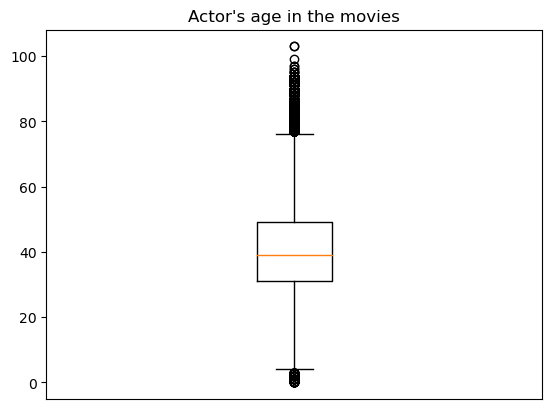

In [136]:
plt.boxplot(characters_male['actor_age_movie'])
plt.xticks([])
plt.title("Actor's age in the movies")